In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import optim


Bad key "text.kerning_factor" on line 4 in
C:\Users\rithw\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Helper function for viewing an image and predicting it's class

In [2]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

## 1. Importing the dataset

In [3]:
transforms_applied = transforms.Compose([transforms.ToTensor()])

trainset = datasets.FashionMNIST("./data", train = True, transform = transforms_applied, download = True )
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True )

testset = datasets.FashionMNIST("./data", train = False, transform = transforms_applied, download = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [4]:
images, labels = next(iter(trainloader))

In [5]:
# Sample Input Image
labels

tensor([3, 6, 0, 7, 5, 5, 4, 3, 4, 3, 9, 2, 3, 7, 7, 0, 6, 3, 7, 8, 2, 7, 9, 6,
        4, 4, 5, 2, 7, 8, 4, 9, 9, 9, 7, 7, 6, 9, 9, 8, 4, 8, 0, 5, 7, 5, 5, 9,
        3, 3, 4, 4, 0, 5, 3, 7, 9, 7, 6, 8, 3, 8, 8, 4])

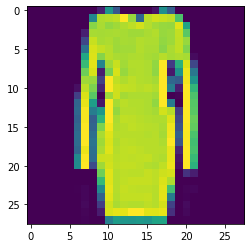

In [6]:
plt.imshow(images[0].view(28,28));

## 2. Defining the architecture of the model

In [7]:
n_input = 784
n_hidden = [256,128,64]
n_output = 10

In [8]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(n_input, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], n_hidden[2])
        self.output = nn.Linear(n_hidden[2], n_output)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.output(x), dim = 1)
        
        return x

In [9]:
model = Network()

## 3. Defining the Criterion and Optimizer 

In [10]:
criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01)

## 4. Training the Neural Network

In [11]:
epochs = 10 

for iterations in range(epochs):
    
    running_loss = 0
    train_loss_array = []
    test_loss_array = []
    
    for images, labels in iter(trainloader):
        
        optimizer.zero_grad()
        
        images = images.view(images.shape[0], -1)
        
        predictions = model.forward(images)
        
        loss = criterion(predictions, labels)

        running_loss += loss
        
        loss.backward()
        
        optimizer.step()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images_test, labels_test in iter(testloader):

                images_test = images_test.view(images_test.shape[0], -1)

                log_predictions = model.forward(images_test)

                loss_testing = criterion(log_predictions, labels_test)

                test_loss += loss_testing

                predictions = torch.exp(log_predictions)


                top_p, top_class = predictions.topk(1, dim = 1)
                equals = top_class == labels_test.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_loss_array.append(running_loss/len(trainloader))
        test_loss_array.append(test_loss/len(testloader))
        
        print("Epoch : {}/{}..." .format(iterations+1, epochs),
             "Training Loss : {:.3f}.." .format(running_loss/len(trainloader)),
             "Test Loss : {:.3f}.." .format(test_loss/len(testloader)),
             "Test Accuracy: {:.3f}" .format(accuracy/len(testloader)))
        


Epoch : 1/10... Training Loss : 1.817.. Test Loss : 1.050.. Test Accuracy: 0.568
Epoch : 2/10... Training Loss : 0.840.. Test Loss : 0.744.. Test Accuracy: 0.714
Epoch : 3/10... Training Loss : 0.674.. Test Loss : 0.664.. Test Accuracy: 0.761
Epoch : 4/10... Training Loss : 0.602.. Test Loss : 0.602.. Test Accuracy: 0.788
Epoch : 5/10... Training Loss : 0.554.. Test Loss : 0.570.. Test Accuracy: 0.794
Epoch : 6/10... Training Loss : 0.519.. Test Loss : 0.543.. Test Accuracy: 0.803
Epoch : 7/10... Training Loss : 0.491.. Test Loss : 0.531.. Test Accuracy: 0.807
Epoch : 8/10... Training Loss : 0.471.. Test Loss : 0.499.. Test Accuracy: 0.821
Epoch : 9/10... Training Loss : 0.452.. Test Loss : 0.469.. Test Accuracy: 0.833
Epoch : 10/10... Training Loss : 0.438.. Test Loss : 0.474.. Test Accuracy: 0.832


## 5. Testing the model

C:\Users\rithw\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


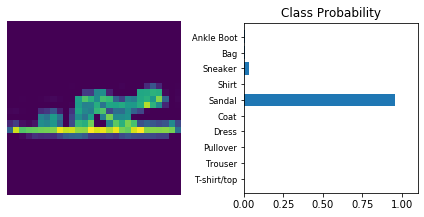

In [12]:
%matplotlib inline

images, labels = next(iter(trainloader))
test_img = images[0].view(1,784)

pred = model.forward(test_img)

# pred contains Logits, need to take softmax to get probabilities
final_pred = F.softmax(pred)

view_classify(test_img.view(1,28,28), final_pred, version = "Fashion")